In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import prince

# Otras tecnicas de agrupamiento

*(Tomado de [https://scikit-learn.org/stable/modules/clustering.html#clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering))*

## Minibatch K-means




[MiniBatchKMeans]((https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) es una variante del algoritmo KMeans que utiliza mini-lotes para reducir el tiempo de cálculo, mientras optimiza la función objetivo. Los mini lotes son subconjuntos de los datos de entrada, muestreados aleatoriamente en cada iteración de entrenamiento. Estos mini lotes reducen drásticamente la cantidad de cálculo necesario para converger en una solución local. A diferencia de otros algoritmos que reducen el tiempo de convergencia de k-medias, las k-medias de mini lotes producen resultados que generalmente son solo un poco peores que el algoritmo estándar.

El algoritmo itera entre dos pasos principales. En el primer paso, las muestras se extraen aleatoriamente del conjunto de datos para formar un mini lote. Luego, estos se asignan al centroide más cercano. En el segundo paso, se actualizan los centroides. A diferencia de las k-medias, esto se hace por muestra. Para cada muestra en el mini-lote, el centroide asignado se actualiza tomando el promedio de transmisión de la muestra y todas las muestras anteriores asignadas a ese centroide. Esto tiene el efecto de disminuir la tasa de cambio de un centroide a lo largo del tiempo. Estos pasos se realizan hasta que se alcanza la convergencia o un número predeterminado de iteraciones.

MiniBatchKMeans converge más rápido que KMeans, pero la calidad de los resultados se reduce. En la práctica, esta diferencia de calidad puede ser bastante pequeña, como se muestra en el ejemplo y la referencia citada.
 

[![img](https://scikit-learn.org/stable/_images/sphx_glr_plot_mini_batch_kmeans_0011.png)](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)

In [ ]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/ICFES/PruebaSaber1.csv"
datos1=pd.read_csv(url, sep=";", encoding="latin1",low_memory=False)
for i in range(11):
    j=i+2
    x=["https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/ICFES/PruebaSaber",j, ".csv"]
    x[1]=str(x[1])
    url="".join(x)
    print(url)
    datosd=pd.read_csv(url, sep=";", encoding="latin1")
    datos1=pd.concat([datos1, datosd])

In [ ]:
datos=datos1.dropna()
cuanti=datos.select_dtypes(exclude=["object"])
cuali=datos.select_dtypes(include=["object"])
# Estandarizar y ACP
escala=StandardScaler(with_mean=True, with_std=True)
escala.fit(cuanti)
datosestan=escala.transform(cuanti)
## Realizo el ACP
pca=PCA(0.9)
pca.fit(datosestan)  ## Ajusto el PCA (valores, vectpores, varianza)
nuevosACP=pca.transform(datosestan)
pca.explained_variance_ratio_
nuevosACP.shape

In [ ]:
%%time
within= [] ### Grafico de codo con Kmeans
for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k).fit(nuevosACP)
    within.append(kmeanModel.inertia_)
fig=px.line(x=list(range(1,10)), y=within)
fig.show()

In [ ]:
%%time
from sklearn.cluster import MiniBatchKMeans
within= []
for k in range(1,10):
    kmeanModel = MiniBatchKMeans(n_clusters=k).fit(nuevosACP)
    within.append(kmeanModel.inertia_)
fig=px.line(x=list(range(1,10)), y=within)
fig.show()

In [ ]:
#### Cuantos grupos harian (2)
kmedias = KMeans(n_clusters=2).fit(nuevosACP)  ### Consume 
MBkmedias= MiniBatchKMeans(n_clusters=2).fit(nuevosACP)

In [ ]:
pd.crosstab(kmedias.labels_,MBkmedias.labels_,margins=True)

In [ ]:
### Ejecutenlo en sus casitas
#base=nuevosACP
#within= {}
#results = {}
#for k in range(2,10):
 #   kmeanModel = MiniBatchKMeans(n_clusters=k).fit(base)
  #  within[k]=kmeanModel.inertia_
   # predictions = kmeanModel.predict(base)
   # results[k] = silhouette_score(base, predictions)
   # print(k)

In [ ]:
# results

## Propagación Afín

[AffinityPropagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation) crea clústeres enviando mensajes entre pares de muestras hasta la convergencia. A continuación, se describe un conjunto de datos utilizando una pequeña cantidad de ejemplos, que se identifican como los más representativos de otras muestras. Los mensajes enviados entre pares representan la idoneidad de una muestra para ser el ejemplar de la otra, que se actualiza en respuesta a los valores de otros pares. Esta actualización ocurre de forma iterativa hasta la convergencia, momento en el que se eligen los ejemplos finales y, por lo tanto, se da el agrupamiento final.

![afpp](https://scikit-learn.org/stable/_images/sphx_glr_plot_affinity_propagation_0011.png)

La propagación por afinidad puede ser interesante, ya que elige el número de grupos en función de los datos proporcionados. Para ello, los dos parámetros importantes son la preferencia, que controla cuántos ejemplares se utilizan, y el factor de amortiguación que amortigua los mensajes de responsabilidad y disponibilidad para evitar oscilaciones numéricas al actualizar estos mensajes.

### Algoritmo:

Sea $x_1$ a $x_n$ un conjunto de datos, sin suposiciones sobre su estructura interna, y sea $s$ una función que cuantifique la similitud entre dos puntos cualesquiera, tal que $s (i, j)> s (i, k)$ si y solo si $x_i$ es más similar a $x_j$ que a $x_k$. 

La diagonal de s (es decir, $s(i, i)$ es particularmente importante, ya que representa la preferencia de la instancia, es decir, la probabilidad de que una instancia en particular se convierta en un ejemplo. Cuando se establece en el mismo valor para todas las entradas, controla cuántas clases produce el algoritmo. Un valor cercano a la similitud mínima posible produce menos clases, mientras que un valor cercano o mayor que la similitud máxima posible produce muchas clases. Por lo general, se inicializa con la similitud mediana de todos los pares de entradas.

El algoritmo procede alternando entre dos pasos de paso de mensajes, que actualizan dos matrices:

La matriz de "responsabilidad" $R$ tiene valores $r(i, k)$ que cuantifican cuán adecuado es $x_k$ para servir como modelo para $x_i$, en relación con otros ejemplos candidatos para $xi$.

La matriz de "disponibilidad" A contiene valores $a(i, k)$ que representan cuán "apropiado" sería para $x_i$ elegir $x_k$ como su ejemplo, teniendo en cuenta la preferencia de otros puntos por $x_k$ como ejemplo.

Ambas matrices se inicializan como ceros y se pueden ver como tablas de probabilidad logarítmica. A continuación, el algoritmo realiza las siguientes actualizaciones de forma iterativa:

Primero, se envían actualizaciones de responsabilidad: 
$$r(i, k) \leftarrow s(i, k) - \max_{k '\neq k} \left\{ a(i, k') + s ( i, k ') \right\} $$

Luego, la disponibilidad se actualiza por

$$a(i, k) \leftarrow \min \left(0, r(k, k) + \sum_{i '\not\in \{i, k \}} \max (0, r( i', k)) \right)$$

para $i\neq k$.

$$a(k, k) \leftarrow \sum_{i '\neq k} \max(0, r (i', k)).$$

Las iteraciones se realizan hasta que los límites del clúster permanecen sin cambios durante una serie de iteraciones o hasta que se alcanza un número predeterminado (de iteraciones). Los ejemplos se extraen de las matrices finales como aquellos cuya "responsabilidad + disponibilidad" para sí mismos es positiva (es decir, $r(i, i) + a(i, i))> 0$).

El principal inconveniente de la propagación por afinidad es su complejidad. El algoritmo tiene una complejidad temporal del orden $O(N^2T)$, donde $N$ es el número de muestras y $T$ es el número de iteraciones hasta la convergencia. Además, la complejidad de la memoria es del orden  $O(N^2)$ si se usa una matriz de similitud densa, aunque es reducible si se usa una matriz de similitud escasa. Esto hace que la propagación de afinidad sea más apropiada para conjuntos de datos de tamaño pequeño a mediano.

In [ ]:
print(__doc__)

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50,random_state=2).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# K-mediods


K-mdioides es un método de clustering muy similar a K-means, la diferencia es que, en K-medioides, cada cluster se centra en una observación presente en el cluster (medioides), mientras que en K-means cada cluster está centrado en su centroide que puede ser una observación lejana a los datos (punto medio).

El medioide es el dato que satisface que el promedio entre él y todos los demás elementos del mismo cluster es lo menor posible. Sería la observación más centrada del cluster, esta idea permite que este método sea más robusto que K-means,pues el ruido no lo afecta. El algoritmo más empleado para aplicar K-medoids se conoce como PAM (Partitioning Around Medoids) y sigue los siguientes pasos:


* Seleccionar K observaciones aleatorias como medioides iniciales. También es posible identificarlas de forma específica.

* Calcular la matriz de distancia entre todas las observaciones si esta no se ha calculado anteriormente.

* Asignar cada observación a su medioide más cercano.

* Para cada uno de los clusters creados, comprobar si seleccionando otra observación como medioide se consigue reducir la distancia promedio del cluster, si esto ocurre, seleccionar la observación que consigue una mayor reducción como nuevo medioide.

* Si al menos un medioide ha cambiado en el paso 4, volver al paso 3, de lo contrario, se termina el proceso.

A diferencia del algoritmo K-means, en el que se minimiza la suma total de cuadrados intra-cluster (suma de las distancias al cuadrado de cada observación respecto a su centroide), el algoritmo K-medioide minimiza la suma de las diferencias de cada observación respecto a su medioide.

Por lo general, el método de K-medioides se utiliza cuando se conoce o se sospecha de la presencia de outliers. Si esto ocurre, es recomendable utilizar como medida de similitud la distancia de Manhattan, ya que es menos sensible a outliers que la euclídea.

***

K-medoids es un método de clustering más robusto que K-means, por lo es más adecuado cuando el set de datos contiene outliers o ruido.

Al igual que K-means, necesita que se especifique de antemano el número de clusters que se van a crear. Esto puede ser complicado de determinar si no se dispone de información adicional sobre los datos. Muchas de las estrategias empleadas en K-means para identificar el número óptimo, pueden aplicarse en K-medoids.

Para sets de datos grandes se necesitan muchos recursos computacionales. En tal situación se recomienda aplicar el método CLARA.
***

El algoritmo K-medoids está implementado en la clase KMedoids de la librería sklearn_extra. Su funcionamiento es análogo al descrito en el apartado de K-means. También está disponible en la librería PyClustering.

Vamos a instalar el paquete [pyclustering](https://pypi.org/project/pyclustering/) y toda la documentación está acá [PYC](https://pyclustering.github.io/docs/0.9.0/html/index.html)


In [ ]:
#!pip install pyclustering


In [ ]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Delitos_Colombia.csv"
cuanti=pd.read_csv(url, sep=";",index_col=0)
cuanti["DSP"]=cuanti.Delitos_Sexuales/cuanti.Poblacion
cuanti["HP"]=cuanti.Homicidios/cuanti.Poblacion
cuanti["IP"]=cuanti.Intrafamiliar/cuanti.Poblacion
cuanti["TP"]=cuanti.Transito/cuanti.Poblacion
cuanti["AP"]=cuanti.Asalto/cuanti.Poblacion
DC=cuanti[["DSP", "HP", "IP", "TP", "AP"]]
## Estandarizar 
escala=StandardScaler(with_mean=True, with_std=True)
escala.fit(DC)
datosestan=escala.transform(DC)
## Realizo el ACP
pca=PCA(0.9)
pca.fit(datosestan)  ## Ajusto el PCA (valores, vectpores, varianza)
nuevosACP=pca.transform(datosestan)
pca.explained_variance_ratio_

In [ ]:
from pyclustering.cluster.kmedoids import kmedoids ## menos sensible a datos atipicos
kmed=kmedoids(nuevosACP,[1,2]) ### la longitud del segundo argumento es el numero de grupos
kmed.process()
a=kmed.get_clusters()
a  ## Problema, como le asigno ese agrupamiento a la base original

In [ ]:
DC
## Adicionar esos labels a la base original

# DBSCAN 
Conexidad entre los datos una introducción al análisis topológico de datos.


La idea es establecer como se están conectando los datos, propuesto en 1996 por Ester como una forma de identificar grupos siguiendo el modo intuitivo en el que lo hace el cerebro humano, identificando regiones con alta densidad de observaciones separadas por regiones de baja densidad.


DBSCAN evita este problema siguiendo la idea de que, para que una observación forme parte de un cluster, tiene que haber un mínimo de observaciones vecinas dentro de un radio de proximidad y de que los clusters están separados por regiones vacías o con pocas observaciones.

El algoritmo DBSCAN necesita dos parámetros:

* **Epsilon  (ϵ)** : radio que define la región vecina a una observación, también llamada  ϵ -neighborhood.

* **Minimum points (min_samples)**: número mínimo de observaciones dentro de la región epsilon.

Empleando estos dos parámetros, cada observación del set de datos se puede clasificar en una de las siguientes tres categorías:

* **Core point**: observación que tiene en su  ϵ -neighborhood un número de observaciones vecinas igual o mayor a min_samples.

* **Border point**: observación no satisface el mínimo de observaciones vecinas para ser core point pero que pertenece al  ϵ -neighborhood de otra observación que sí es core point.

* **Noise u outlier**: observación que no es core point ni border point.

Por último, empleando las tres categorías anteriores se pueden definir tres niveles de conectividad entre observaciones:

* **Directamente alcanzable (direct density reachable)**: una observación  A  es directamente alcanzable desde otra observación  B  si  A  forma parte del  ϵ -neighborhood de  B  y  B  es un core point. Por definición, las observaciones solo pueden ser directamente alcanzables desde un core point.

* **Alcanzable (density reachable)**: una observación  A  es alcanzable desde otra observación  B  si existe una secuencia de core points que van desde  B  a  A .

* **Densamente conectadas (density conected)**: dos observaciones  A  y  B  están densamente conectadas si existe una observación core point  C  tal que  A  y  B  son alcanzables desde  C .

La siguiente imagen muestra las conexiones existentes entre un conjunto de observaciones si se emplea  minsamples=4 . La observación  A  y el resto de observaciones marcadas en rojo son core points, ya que todas ellas contienen al menos 4 observaciones vecinas (incluyéndose a ellas mismas) en su  ϵ -neighborhood. Como todas son alcanzables entre ellas, forman un cluster. Las observaciones  B  y  C  no son core points pero son alcanzables desde  A  a través de otros core points, por lo tanto, pertenecen al mismo cluster que  A . La observación  N  no es ni un core point ni es directamente alcanzable, por lo que se considera como ruido.

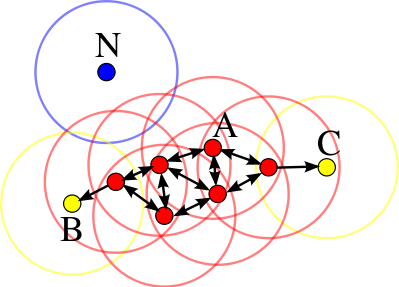

**Algoritmo**


1. Para cada observación  $x_i$  calcular la distancia entre ella y el resto de observaciones. Si en su  ϵ -neighborhood hay un número de observaciones  '≥minsamples'  marcar la observación como core point, de lo contrario marcarla como visitada.

2. Para cada observación  $x_i$  marcada como core point, si todavía no ha sido asignada a ningún cluster, crear uno nuevo y asignarla a él. Encontrar recursivamente todas las observaciones densamente conectadas a ella y asignarlas al mismo cluster.

3. Iterar el mismo proceso para todas las observaciones que no hayan sido visitadas.

4. Aquellas observaciones que tras haber sido visitadas no pertenecen a ningún cluster se marcan como outliers.

Como resultado, todo cluster cumple dos propiedades: todos los puntos que forman parte de un mismo cluster están densamente conectados entre ellos y, si una observación  A  es densamente alcanzable desde cualquier otra observación de un cluster, entonces  A  también pertenece al cluster.


**Hiperparámetros**


Como ocurre en muchas otras técnicas estadísticas, en DBSCAN no existe una forma única y exacta de encontrar el valor adecuado de epsilon  (ϵ)  y  minsamples . A modo orientativo se pueden seguir las siguientes premisas:

minsamples : cuanto mayor sea el tamaño del set de datos, mayor debe ser el valor mínimo de observaciones vecinas. En el libro Practical Guide to Cluster Analysis in R recomiendan no bajar nunca de 3. Si los datos contienen niveles altos de ruido, aumentar  minsamples  favorecerá la creación de clusters significativos menos influenciados por outliers.

epsilon: una buena forma de escoger el valor de  ϵ  es estudiar las distancias promedio entre las  k=minsamples  observaciones más próximas. Al representar estas distancias en función de  ϵ , el punto de inflexión de la curva suele ser un valor óptimo. Si el valor de  ϵ  escogido es muy pequeño, una proporción alta de las observaciones no se asignarán a ningún cluster, por el contrario, si el valor es demasiado grande, la mayoría de observaciones se agruparán en un único cluster.


**Ventajas y desventajas**


***Ventajas***

No requiere que el usuario especifique el número de clusters.

Es independiente de la forma que tengan los clusters.

Puede identificar outliers, por lo que los clusters generados no se ven influenciados por ellos.


***Desventajas***

Es un método determinístico siempre y cuando el orden de los datos sea el mismo. Los border points que son alcanzables desde más de un cluster pueden asignarse a uno u otro dependiendo del orden en el que se procesen los datos.

No genera buenos resultados cuando la densidad de los grupos es muy distinta, ya que no es posible encontrar los parámetros  ϵ  y min_samples que sirvan para todos a la vez.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

#Datos
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/multishape.csv'
datos = pd.read_csv(url)
datos.head()


X = datos.drop(columns='shape').to_numpy()
X_scaled = scale(X)

#modelo
modelo_dbscan = DBSCAN(
                    eps          = 0.2,
                    min_samples  = 5,
                    metric       = 'euclidean',
                )

modelo_dbscan.fit(X=X_scaled)


labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X[:, 0],
    y = X[:, 1], 
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X[labels == -1, 0],
    y = X[labels == -1, 1], 
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');





In [ ]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

### Otro ejemplo

In [ ]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=2).fit(nuevosACP)
dbscan.labels_

In [ ]:
dbscan=DBSCAN(eps=1.5).fit(nuevosACP)

features = DC.columns

components = pca.fit_transform(datosestan)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=dbscan.labels_.astype(str))

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

# Fuzzy Clustering

In [ ]:
from pyclustering.samples.definitions import FAMOUS_SAMPLES
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm
from pyclustering.utils import read_sample
# load list of points for cluster analysis
sample = read_sample(FAMOUS_SAMPLES.SAMPLE_OLD_FAITHFUL)
# initialize
initial_centers = kmeans_plusplus_initializer(sample, 2, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(sample, initial_centers)
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()
# visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, marker='*', markersize=10)
visualizer.show()